## Extracción de Features para clasificación de ECG's

In [2]:
import pandas as pd
import glob
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from joblib import Parallel, delayed
import multiprocessing

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from neurokit2 import ecg
import neurokit2 as nk

from models.rnn import CRNN_Model


SAMPLING_RATE = 1000
SAMPLES_PER_CLASS = 1970
MAX_WORKERS = 8
PRE_DISPATCH = '2*n_jobs'

LEADS = ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']

class_folders = {
    'arritmia': 0,
    'block': 1,
    'fibrilation': 2,
    'normal': 3
}

data_folder = 'data'


### Función de extracción de features
Por cáda examen, se extrae:
- Media NN, SDNN, RMSSD, y pNN50 de la lead II (4 componentes).
- Promedio de las alturas de cada onda (P, Q, R, S) para cada lead (48 componentes). 

Posteriormente, para procesar todo el dataset, se aplica la función a cada examen de forma paralela usando `joblib`.

In [3]:
def toFeature(signal: pd.core.frame.DataFrame, time = False):
    time_features = ["HRV_MeanNN", "HRV_SDNN", "HRV_RMSSD", "HRV_pNN50"]
    F = []
    for lead in LEADS:
        clean = nk.ecg_clean(signal[lead], sampling_rate=SAMPLING_RATE)
        _, rpeaks = nk.ecg_peaks(clean, sampling_rate=SAMPLING_RATE)
        rpeak_indices = rpeaks['ECG_R_Peaks']
        # Pasar de largo si no hay suficientes R-peaks
        if np.sum(rpeak_indices) < 2:
            F += [np.nan, np.nan, np.nan, np.nan]
            continue
        try:
            _, waves_peak = nk.ecg_delineate(clean, rpeaks, sampling_rate=SAMPLING_RATE, method="peak")
            mean_r = np.mean([clean[i] if not np.isnan(i) else 0 for i in rpeaks['ECG_R_Peaks']]) if np.any(rpeaks['ECG_R_Peaks']) else np.nan
            mean_p = np.mean([clean[i] if not np.isnan(i) else 0 for i in waves_peak['ECG_P_Peaks']]) if 'ECG_P_Peaks' in waves_peak else np.nan
            mean_q = np.mean([clean[i] if not np.isnan(i) else 0 for i in waves_peak['ECG_Q_Peaks']]) if 'ECG_Q_Peaks' in waves_peak else np.nan
            mean_s = np.mean([clean[i] if not np.isnan(i) else 0 for i in waves_peak['ECG_S_Peaks']]) if 'ECG_S_Peaks' in waves_peak else np.nan
        except Exception:
            mean_r = mean_p = mean_q = mean_s = np.nan
        F += [mean_r, mean_p, mean_q, mean_s]
    # Features temporales con lead II:
    clean2 = nk.ecg_clean(signal["II"], sampling_rate=SAMPLING_RATE)
    _, rpeaks = nk.ecg_peaks(clean2, sampling_rate=SAMPLING_RATE)
    valid_rpeaks = [r for r in rpeaks['ECG_R_Peaks'] if not np.isnan(r)]
    if len(valid_rpeaks) >= 2: # Seguir de largo si no hay R-peaks suficientes
        if time:
            t = nk.hrv_time(rpeaks, sampling_rate=SAMPLING_RATE)
            F.extend(t[time_features].values.flatten().tolist())
    else:
        nan_count = 0
        if time: nan_count += len(time_features)
        F.extend([np.nan] * nan_count)
    return np.array(F)

### Lectura de archivos y sampleo

Arritmia: 7545 
Block: 2329 (-2)
Fibrilation: 1970
Normal: 7369 (-1)

Algunos exámenes fueron eliminados por estar vacíos. Pesaban 2kb y hacían que el código se caiga. (8846 (B), 314864 (B), 74424 (N))

El balanceo de clases se logra escogiendo sampleando la mínima cantidad tal que se utilicen todos los exámenes de la clase menos representada (fibrilation, con 1970 ECG's). 

En otra prueba se intentará agrupar Normales v/s Anormales. 

In [4]:

n_jobs = -1  
verbose = 3
# samplear paths
file_items = []
for folder, label in class_folders.items():
    paths = glob.glob(os.path.join(data_folder, folder, '*.parquet.gzip'))
    if len(paths) >= SAMPLES_PER_CLASS:
        sampled = random.sample(paths, SAMPLES_PER_CLASS)
    else:
        sampled = random.choices(paths, k=SAMPLES_PER_CLASS)
    file_items.extend([(p, label) for p in sampled])

# leer paths sampleados y aplicar función
def _process_file(path_label):
    path, label = path_label
    try:
        df = pd.read_parquet(path, engine='fastparquet')
        if not set(LEADS).issubset(df.columns):
            return None, label, os.path.basename(path)
        df_leads = df[LEADS].apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)
        feat = toFeature(df_leads, time=True)  # keep inner work single-threaded
        return feat, label, os.path.basename(path)
    except Exception as e:
        return None, label, os.path.basename(path)

# obtener número de trabajadores y ejecutar función de procesamiento en paralelo
cpu_count = multiprocessing.cpu_count()
if MAX_WORKERS == -1:
    workers = max(1, cpu_count - 1)
else:
    workers = min(max(1, cpu_count - 1), MAX_WORKERS)

results = Parallel(n_jobs=workers, backend='loky', verbose=verbose, pre_dispatch=PRE_DISPATCH)(
    delayed(_process_file)(item) for item in file_items
)
# checkear si hay alguno inválido
first_valid = next((r[0] for r in results if r[0] is not None), None)
if first_valid is None:
    raise RuntimeError("No hay features válidas")
feat_len = len(first_valid)

# juntar en arrays
features = np.vstack([
    (r[0] if (r[0] is not None and len(r[0]) == feat_len) else np.full(feat_len, np.nan))
    for r in results
])
labels = np.array([r[1] for r in results])
ecg_ids = [r[2] for r in results]

imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)  # rellenar nan's con la media

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:   13.3s
[Parallel(n_jobs=7)]: Done 114 tasks      | elapsed:   39.2s
[Parallel(n_jobs=7)]: Done 274 tasks      | elapsed:  1.4min
[Parallel(n_jobs=7)]: Done 498 tasks      | elapsed:  2.5min
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:  3.8min
[Parallel(n_jobs=7)]: Done 1138 tasks      | elapsed:  5.6min
[Parallel(n_jobs=7)]: Done 1554 tasks      | elapsed:  7.4min
[Parallel(n_jobs=7)]: Done 2034 tasks      | elapsed:  9.5min
[Parallel(n_jobs=7)]: Done 2578 tasks      | elapsed: 12.2min
[Parallel(n_jobs=7)]: Done 3186 tasks      | elapsed: 15.0min
[Parallel(n_jobs=7)]: Done 3858 tasks      | elapsed: 18.1min
[Parallel(n_jobs=7)]: Done 4594 tasks      | elapsed: 21.9min
[Parallel(n_jobs=7)]: Done 5394 tasks      | elapsed: 26.1min
[Parallel(n_jobs=7)]: Done 6258 tasks      | elapsed: 30.7min
[Parallel(n_jobs=7)]: Done 7186 tasks      | elapsed: 35.2min


### Visualización de PCA(n=2)

Para ver si hay alguna estructura en los datos al proyectarlos a sus componentes principales. También se prueba la efectividad del clasificador KNN. El rendimiento es apenas mejor que clasificar al azar, y la única estructura visible es una aglomeración de los exámenes normales.

KNN accuracy: 0.3413705583756345


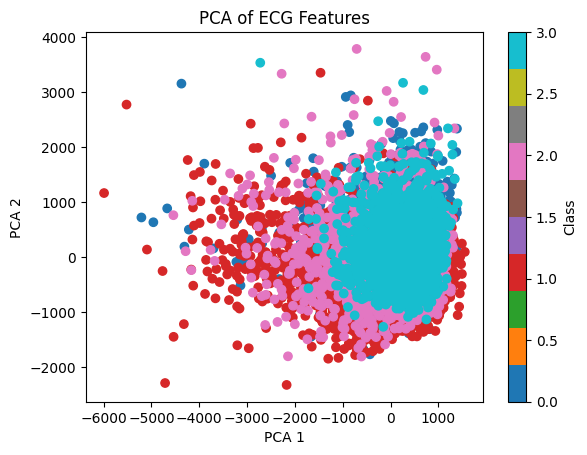

In [5]:
# PCA

pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_imputed)

# KNN

X_train, X_test, y_train, y_test = train_test_split(features_pca, labels, test_size=0.2, random_state=42)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print("KNN accuracy:", knn.score(X_test, y_test))

plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='tab10')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of ECG Features')
plt.colorbar(label='Class')
plt.show()

### Pruebas con distintos modelos

#### MLP

In [6]:
from sklearn.neural_network import MLPClassifier
X_train, X_test, y_train, y_test = train_test_split(features_imputed, labels, test_size=0.2, random_state=42)
clf = MLPClassifier(random_state=1, max_iter=30000, learning_rate='adaptive').fit(X_train, y_train)
clf.predict_proba(X_test[:1])
clf.predict(X_test[:5, :])
clf.score(X_test, y_test)

0.6491116751269036

#### NaiveBayes

In [7]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB().fit(X_train, y_train)
clf.score(X_test, y_test)

0.6008883248730964

#### Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
rf = RandomForestClassifier(n_estimators=5000, warm_start=True)


In [9]:
rf.fit(X_train, y_train)
print(rf.n_features_in_, rf.score(X_test, y_test))
y_pred = rf.predict(X_test)
print("F1 score (weighted):", f1_score(y_test, y_pred, average='weighted'))

52 0.8147208121827412
F1 score (weighted): 0.815697381075588


#### PCA(n=$2,\dots,52$)

In [10]:
scores = []
knn = KNeighborsClassifier(n_neighbors=4)
for n in range(51):
    pca = PCA(n_components=n+2)
    features_pca = pca.fit_transform(features_imputed)
    X_train, X_test, y_train, y_test = train_test_split(features_pca, labels, test_size=0.2, random_state=42)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))

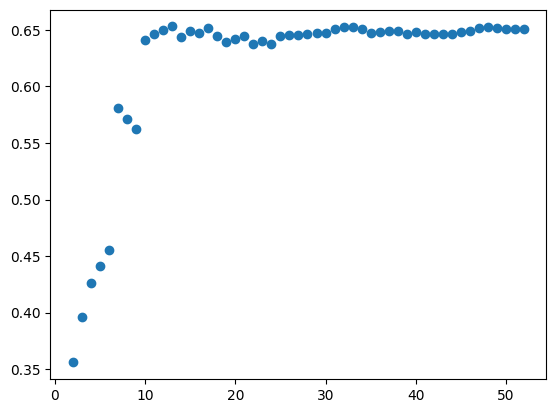

In [11]:
plt.scatter([i+2 for i in range(51)], scores)

### Random Forest
#### Variar `n_estimators`

In [12]:
scores_rf = []
X_train, X_test, y_train, y_test = train_test_split(features_imputed, labels, test_size=0.2, random_state=42)
for n in range(1, 11):
    rf = RandomForestClassifier(n_estimators=1000*n, warm_start=True)
    rf.fit(X_train, y_train)
    scores_rf.append(rf.score(X_test, y_test))
    

KeyboardInterrupt: 

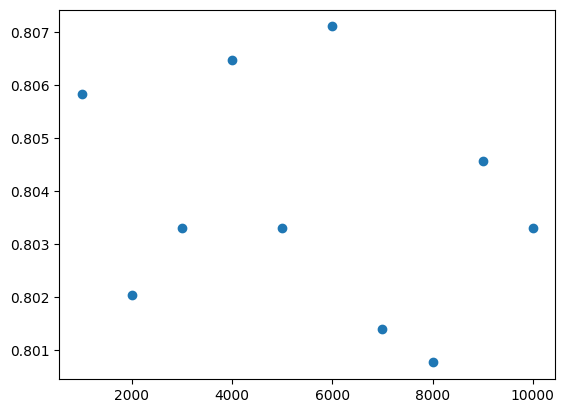

In [ ]:
plt.scatter([1000*i for i in range(1, 11)], scores_rf)

#### Variar `max_features`

In [13]:
scores_rf2 = []
X_train, X_test, y_train, y_test = train_test_split(features_imputed, labels, test_size=0.2, random_state=42)
for n in range(2,51, 5):
    print(f"Probando con {n+2} features")
    rf = RandomForestClassifier(n_estimators=3000, max_features=n+2, warm_start=True, n_jobs=-1)
    rf.fit(X_train, y_train)
    scores_rf2.append(rf.score(X_test, y_test))
    

Probando con 4 features
Probando con 9 features
Probando con 14 features
Probando con 19 features
Probando con 24 features
Probando con 29 features
Probando con 34 features
Probando con 39 features
Probando con 44 features
Probando con 49 features


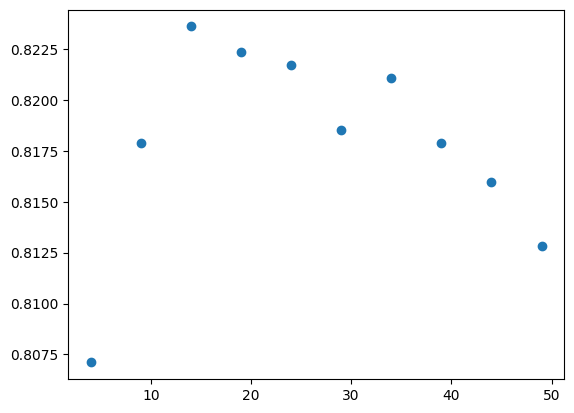

In [14]:
plt.scatter([i+2 for i in range(2,51,5)], scores_rf2)

### Feature importance

In [15]:
# 1. Recrear tu lista de 52 features
leads = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
waves = ['P', 'Q', 'R', 'S']
hrv_features = ["HRV_MeanNN", "HRV_SDNN", "HRV_RMSSD", "HRV_pNN50"]

# Crear las 48 features de ondas (ej: 'I_P', 'I_Q', 'I_R', 'I_S', 'II_P', ...)
wave_features = [f"{lead}_{wave}" for lead in leads for wave in waves]

# Lista completa de 52 features
feature_names = wave_features + hrv_features

In [16]:
rf = RandomForestClassifier(n_estimators=5000, warm_start=True, n_jobs=-1)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(features_imputed, labels, test_size=0.2)
rf.fit(X_train, y_train)

,n_estimators,5000
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Feature Importance del Random Forest:
       Feature  Importance
48  HRV_MeanNN    0.164843
50   HRV_RMSSD    0.062265
49    HRV_SDNN    0.053175
51   HRV_pNN50    0.046417
7         II_S    0.033653
5         II_Q    0.030204
1          I_Q    0.029113
24        V1_P    0.027273
23       aVF_S    0.026577
12       aVR_P    0.023786
6         II_R    0.023484
46        V6_R    0.022641
42        V5_R    0.017429
3          I_S    0.016590
2          I_R    0.015554


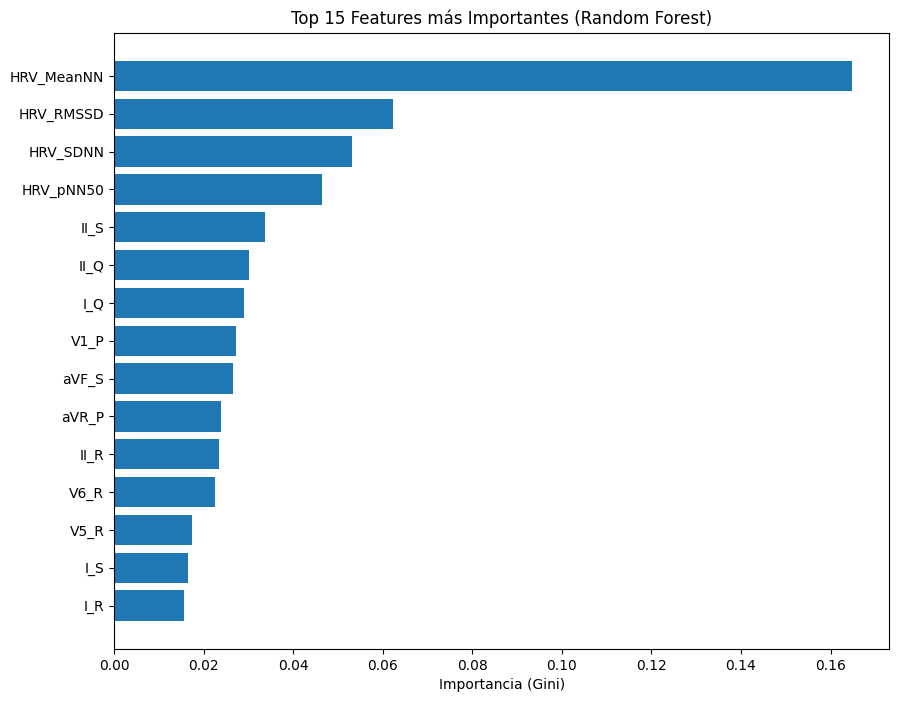

In [18]:
importances = rf.feature_importances_

# 2. Crear un DataFrame de Pandas para verlas fácilmente
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 3. Ordenar por importancia (de mayor a menor)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# --- Mostrar las más importantes ---
print("Feature Importance del Random Forest:")
print(feature_importance_df.head(15)) # Muestra las 15 más importantes

# --- Visualizar las más importantes ---
plt.figure(figsize=(10, 8))
plt.title('Top 15 Features más Importantes (Random Forest)')
plt.barh(feature_importance_df['Feature'].head(15), 
         feature_importance_df['Importance'].head(15),
         align='center')
plt.gca().invert_yaxis() # Pone la más importante arriba
plt.xlabel('Importancia (Gini)')
plt.show()